In [2]:
import pandas as pd
import numpy as np
import random as rnd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

sns.set_style("white")
survived = ["#ffb3ba", "#bae1ff"]
sns.set_palette(survived)
#sns.palplot(sns.color_palette())

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/train.csv


# The Challenge

"The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc)."

https://www.kaggle.com/c/titanic/overview/

# Data

In [3]:
train_df = pd.read_csv("../input/titanic/train.csv")
test_df = pd.read_csv("../input/titanic/test.csv")

train_df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


## Data Types, Describing Data and Missing Values

In [4]:
train_df.info()
print('_'*40)

test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Passenger

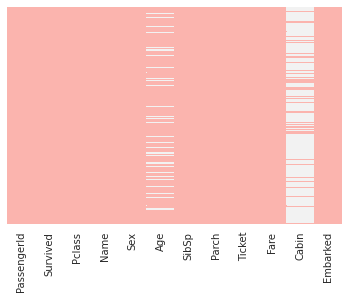

In [5]:
sns.heatmap(train_df.isnull(),yticklabels=False,cbar=False, cmap="Pastel1")

> Visually, Cabin features most missing values.

**Analysing Features & Initial Data Presumptions:**

* PassengerId: is a running index (we will drop this feature later on);

* Survived: indication whether the passenger survived (1) or not (0);

* Pclass: Ticket-class: first (1), second (2), and third (3) class tickets. We might assume that first PClass might correlate positively with the Fare feature as a higher class should cost more relative to second or third ticket-classes;

* Name: Name of the passenger. Names contain the family name (indicating possible family relations), titles, such as Mr., Miss., Mrs. (indicating certain age groups or even possibly correlating to Pclass if the name contains a nobility title);

* Sex: indicator whether the passenger was (female) or (male);

* Age: the age in years of the passenger. Listed as a float64, it might be corectly converted to int64 as no decimal age notation was registered. There are 177 NaN values in the train_df and 86 NaN values in the test_df. To estimate some of those missing values, we might use some of the name titles indicating certain age groups;

* SibSp: number of siblings / spouses aboard the Titanic associated with the passenger;

* Parch: number of parents / children aboard the Titanic associated with the passenger;

* Ticket: alphanumeric variable indicating the ticket number. (If totally random, we might as well drop it too later on);

* Fare: how much each passenger paid for the ticket; There's a single missing-value in the test_df;

* Cabin: cabin number of each passenger. Around 77% and 78% of the values are missing for the train_df and test_df respectively;

* Embarked: shows the port of embarkation as a categorical character value. Either (C), (S) or (Q) (C = Cherbourg; Q = Queenstown; S = Southampton);

# Exploratory Data Analysis (EDA)

## How Many Survived?

In [6]:
survived = train_df[train_df['Survived']==1]
not_survived = train_df[train_df['Survived']==0]

print("Survived: %i (%.1f percent)\nNot Survived: %i (%.1f percent)\nTotal: %i"\
      %(len(survived), 1.*len(survived)/len(train_df)*100.0,\
        len(not_survived), 1.*len(not_survived)/len(train_df)*100.0, len(train_df)))

Survived: 342 (38.4 percent)
Not Survived: 549 (61.6 percent)
Total: 891


In order to have a better predictive algorithm, we must achieve better than 61.6% accuracy. (Same as predicting everyone dies)

## Age Analysis

> Converting Age to integer

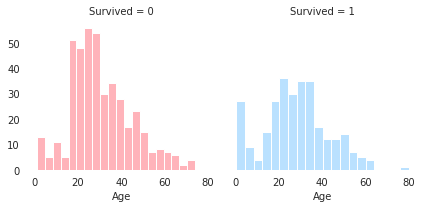

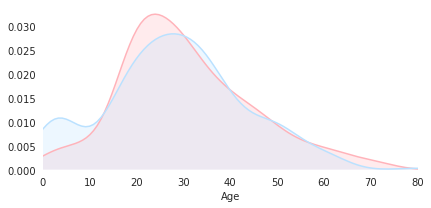

In [7]:
g = sns.FacetGrid(train_df, col='Survived',hue='Survived')
g.map(plt.hist, "Age",bins=20);
sns.despine(left = True,bottom = True)

a = sns.FacetGrid(train_df, hue = 'Survived',aspect=2 )
a.map(sns.kdeplot, 'Age', shade= True)
a.set(xlim=(0 , train_df['Age'].max()))
sns.despine(left = True,bottom = True)

> The y-axis of a KDE plot represents the Kernel Density Estimate (KDE) of the Probability Density Function (PDF) of a random variable, interpreted as a probability differential. The probability of a value being between two x values is the total area under the curve.

**Graphical Observations Regarding Age vs Survival Probability**
* Children under 8 years old had high survival rate;
* Passengers above 40 years old had split odds of survival;
* Most passengers that did not survive were between 16 and 32 years old;



> Unfortunatly, around 20% of the combined dataframe does not have an 'Age' value.

## Sex Analysis

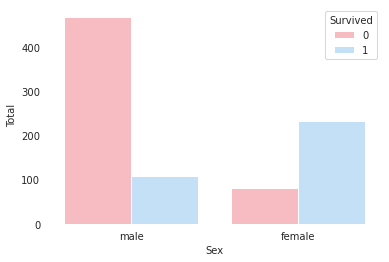

In [8]:
ax = sns.countplot(x = 'Sex', hue = 'Survived', data = train_df)
ax.set(xlabel = 'Sex', ylabel='Total')
sns.despine(left = True,bottom = True)

Graphical Observations Regarding Sex vs Survival Probability

* 74% of Females Survived vs 19% of Males Survived

## PClass Analysis

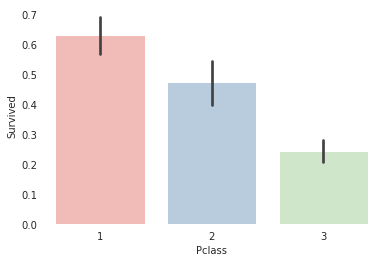

In [9]:
sns.barplot(x='Pclass', y='Survived', palette='Pastel1', data=train_df)
sns.despine(left = True,bottom = True)


## Embarked

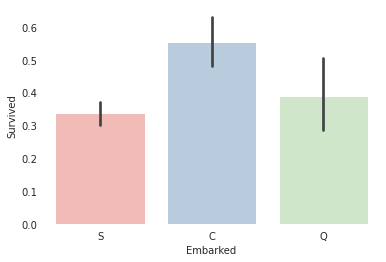

In [10]:
sns.barplot(x='Embarked', y='Survived', palette='Pastel1', data=train_df)
sns.despine(left = True,bottom = True)

## Fare

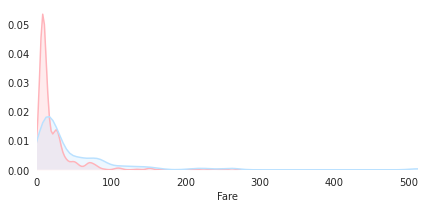

In [11]:
a = sns.FacetGrid(train_df, hue = 'Survived',aspect=2 )
a.map(sns.kdeplot, 'Fare', shade= True)
a.set(xlim=(0 , train_df['Fare'].max()))
sns.despine(left = True,bottom = True)

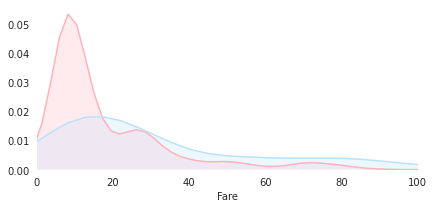

In [12]:
a = sns.FacetGrid(train_df, hue = 'Survived',aspect=2 )
a.map(sns.kdeplot, 'Fare', shade= True)
a.set(xlim=(0 , 100))
sns.despine(left = True,bottom = True)

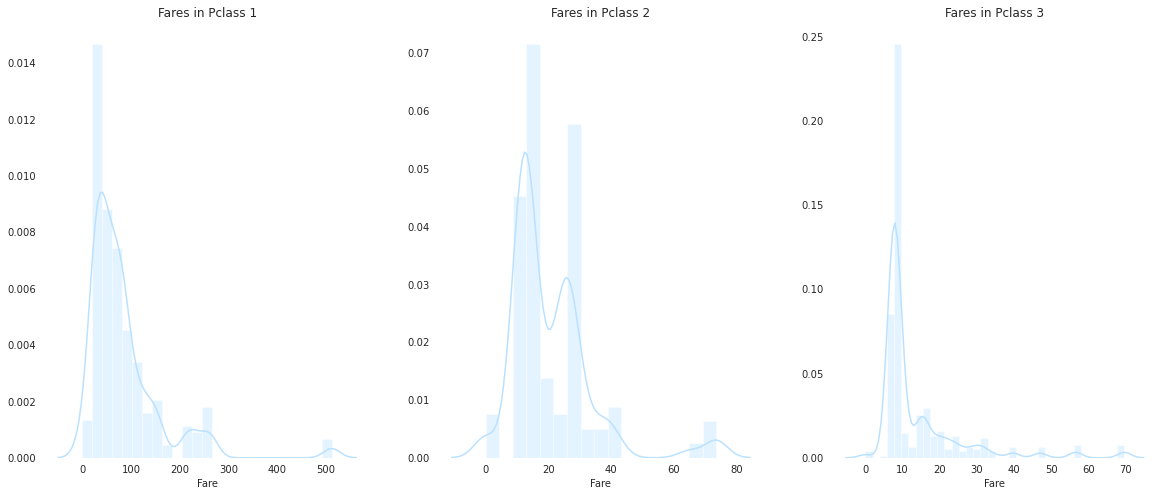

In [13]:
f,ax=plt.subplots(1,3,figsize=(20,8))
sns.distplot(train_df[train_df['Pclass']==1].Fare,ax=ax[0], color="#bae1ff")
ax[0].set_title('Fares in Pclass 1')
sns.distplot(train_df[train_df['Pclass']==2].Fare,ax=ax[1],color="#bae1ff")
ax[1].set_title('Fares in Pclass 2')
sns.distplot(train_df[train_df['Pclass']==3].Fare,ax=ax[2],color="#bae1ff")
ax[2].set_title('Fares in Pclass 3')
sns.despine(left = True,bottom = True)
plt.show()

# Feature Engineering

In [14]:
train_test_df = [train_df, test_df]

## Sex

In [15]:
sex_mapping = {'male': 0, 'female': 1}
for df in train_test_df:
    df['Sex'] = df['Sex'].map(sex_mapping)

## Embarked

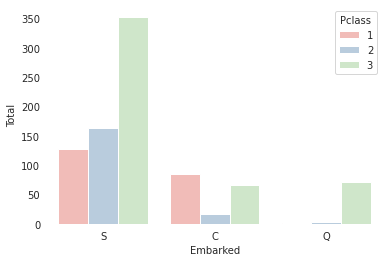

In [16]:
ax = sns.countplot(x = 'Embarked', hue = 'Pclass', palette='Pastel1', data = train_df)
ax.set(xlabel = 'Embarked', ylabel='Total')
sns.despine(left = True,bottom = True)

In [17]:
train_test_df = [train_df, test_df]

for df in train_test_df:
    df['Embarked'] = df['Embarked'].fillna('S')

In [18]:
emb_mapping = {'S': 0, 'C': 1, 'Q': 2}
for df in train_test_df:
    df['Embarked'] = df['Embarked'].map(emb_mapping)

## SibSp and Parch Analysis

In [19]:
train_df['FamilySize'] = train_df['SibSp'] + train_df['Parch'] + 1
test_df['FamilySize'] = test_df['SibSp'] + test_df['Parch'] + 1

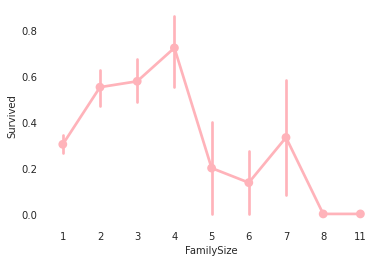

In [20]:
train_df[['FamilySize', 'Survived']].groupby(['FamilySize'], as_index=False).mean().sort_values(by='Survived', ascending=False)
axes = sns.pointplot('FamilySize','Survived', data=train_df)
sns.despine(left = True,bottom = True)

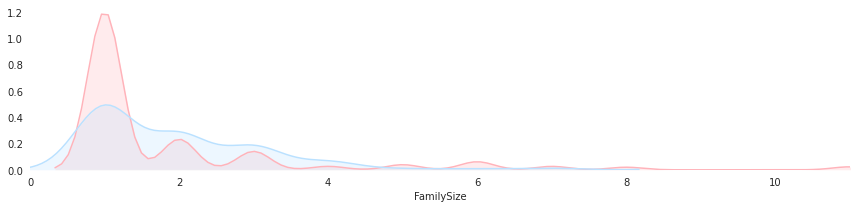

In [21]:
facet = sns.FacetGrid(train_df, hue='Survived', aspect=4)
facet.map(sns.kdeplot, 'FamilySize', shade=True)
facet.set(xlim=(0, train_df['FamilySize'].max()))
plt.xlim(0)
sns.despine(left = True,bottom = True)

In [22]:
train_df = train_df.drop(['Parch','SibSp'], axis=1)
test_df = test_df.drop(['Parch','SibSp'], axis=1)

## Name Analysis
In order to fill most accuratly the missing-values associated with Age and further detail our Exploratory Data Analysis, let's extract titles from passenger names. Not only grouping the final result by Pclass should improve our estimates, most importantly we should group by Parch as most definitely it will present the most discrepencies regarding the mean age (e.g. a "Miss" title may translate a group age of either a child, yound-adult or adult, depending whether or not the person is accompanied by other famility members).

In [23]:
train_test_df = [train_df, test_df]

for df in train_test_df:
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

In [24]:
train_df['Title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Major         2
Mlle          2
Col           2
Jonkheer      1
Don           1
Ms            1
Sir           1
Capt          1
Lady          1
Countess      1
Mme           1
Name: Title, dtype: int64

In [25]:
test_df['Title'].value_counts()

Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Dr          1
Dona        1
Ms          1
Name: Title, dtype: int64

In [26]:
TitleDict = {"Capt": "Officer","Col": "Officer","Major": "Officer","Jonkheer": "Nobility", \
             "Don": "Nobility", "Sir" : "Nobility","Dr": "Nobility","Rev": "Nobility", \
             "Countess":"Nobility", "Mme": "Mrs", "Mlle": "Miss", "Ms": "Mrs","Mr" : "Mr", \
             "Mrs" : "Mrs","Miss" : "Miss","Master" : "Master","Lady" : "Nobility", 'Dona':'Nobility'}

for df in train_test_df:
    df['Title'] = df['Title'].map(TitleDict)

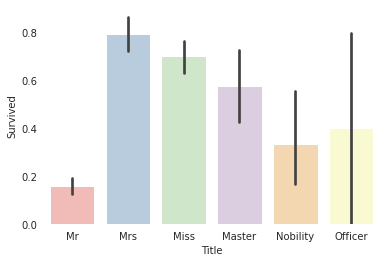

In [27]:
sns.barplot(x='Title', y='Survived', palette='Pastel1', data=train_df)
sns.despine(left = True, bottom = True)

In [28]:
title_mapping = {"Master": 0, "Miss": 1, "Mr": 2, "Mrs": 3, "Nobility": 4, "Officer": 5}

for df in train_test_df:
    df['Title'] = df['Title'].map(title_mapping)

In [29]:
train_df.drop('Name', axis = 1, inplace = True)
test_df.drop('Name', axis = 1, inplace = True)

train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,FamilySize,Title
0,1,0,3,0,22.0,A/5 21171,7.2500,NaN,0,2,2
1,2,1,1,1,38.0,PC 17599,71.2833,C85,1,2,3
2,3,1,3,1,26.0,STON/O2. 3101282,7.9250,NaN,0,1,1
3,4,1,1,1,35.0,113803,53.1000,C123,0,2,3
4,5,0,3,0,35.0,373450,8.0500,NaN,0,1,2


## Age

In [30]:
train_df_corr = train_df.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
train_df_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
train_df_corr[train_df_corr['Feature 1'] == 'Age']

,Feature 1,Feature 2,Correlation Coefficient
7,Age,Age,1.000000
13,Age,Title,0.510545
15,Age,Pclass,0.369226
20,Age,FamilySize,0.301914
40,Age,Fare,0.096067
42,Age,Sex,0.093254
49,Age,Survived,0.077221
66,Age,PassengerId,0.036847
78,Age,Embarked,0.010171


In [31]:
train_df.groupby(['Title', 'Pclass','FamilySize'])['Age'].agg(['mean', 'count'])

mean  count
Title Pclass FamilySize                  
0     1      3            4.000000      1
             4            5.960000      2
      2      3            2.416250      8
             4            1.000000      1
      3      2            6.140000      3
...                            ...    ...
4     1      3           47.000000      2
      2      1           42.333333      6
             2           41.000000      2
5     1      1           53.250000      4
             3           70.000000      1

[74 rows x 2 columns]

In [32]:
for df in train_test_df:
    df['Age'].fillna(df.groupby(['Title','Pclass','FamilySize'])['Age'].transform('mean'), inplace=True)

In [33]:
for df in train_test_df:
    df['Age'].fillna(df.groupby(['Title','Pclass'])['Age'].transform('mean'), inplace=True)

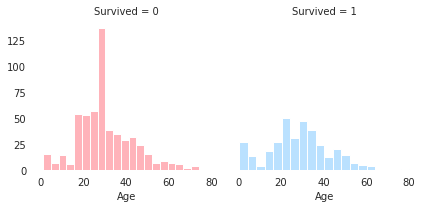

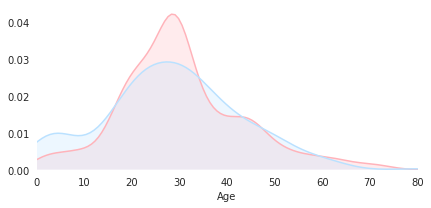

In [34]:
sns.set_style("white")
survived = ["#ffb3ba", "#bae1ff"]
sns.set_palette(survived)
#sns.palplot(sns.color_palette())

g = sns.FacetGrid(train_df, col='Survived',hue='Survived')
g.map(plt.hist, "Age",bins=20);
sns.despine(left = True,bottom = True)

a = sns.FacetGrid(train_df, hue = 'Survived',aspect=2 )
a.map(sns.kdeplot, 'Age', shade= True)
a.set(xlim=(0 , train_df['Age'].max()))
sns.despine(left = True,bottom = True)

(0.0, 16.0)

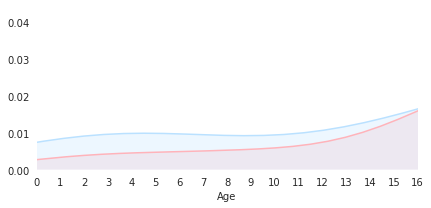

In [35]:
facet = sns.FacetGrid(train_df, hue = 'Survived',aspect=2 )
facet.map(sns.kdeplot, 'Age', shade= True)
facet.set(xlim=(0 , train_df['Age'].max()))
sns.despine(left = True,bottom = True)
facet.set(xticks=np.arange(0,21,1))
plt.xlim(0, 16)

(17.0, 34.0)

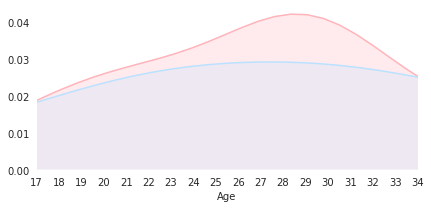

In [36]:
facet = sns.FacetGrid(train_df, hue = 'Survived',aspect=2 )
facet.map(sns.kdeplot, 'Age', shade= True)
facet.set(xlim=(0 , train_df['Age'].max()))
sns.despine(left = True,bottom = True)
facet.set(xticks=np.arange(17,35,1))
plt.xlim(17, 34)

(35.0, 60.0)

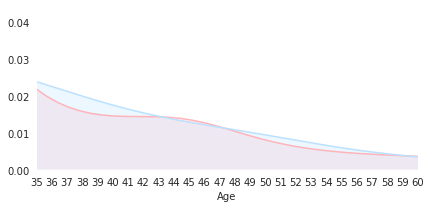

In [37]:
facet = sns.FacetGrid(train_df, hue = 'Survived',aspect=2 )
facet.map(sns.kdeplot, 'Age', shade= True)
facet.set(xlim=(0 , train_df['Age'].max()))
sns.despine(left = True,bottom = True)
facet.set(xticks=np.arange(35,61,1))
plt.xlim(35, 60)

(35.0, 60.0)

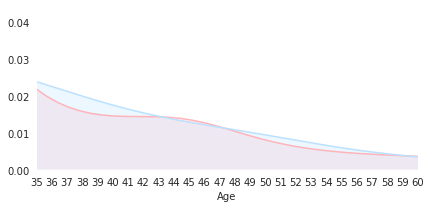

In [38]:
facet = sns.FacetGrid(train_df, hue = 'Survived',aspect=2 )
facet.map(sns.kdeplot, 'Age', shade= True)
facet.set(xlim=(0 , train_df['Age'].max()))
sns.despine(left = True,bottom = True)
facet.set(xticks=np.arange(35,61,1))
plt.xlim(35, 60)

In [39]:
for df in train_test_df:
    df.loc[df['Age'] <= 16, 'Age'] = 0
    df.loc[(df['Age'] > 16) & (df['Age'] <= 34), 'Age'] = 1
    df.loc[(df['Age'] > 34) & (df['Age'] <= 43), 'Age'] = 2
    df.loc[(df['Age'] > 43) & (df['Age'] <= 60), 'Age'] = 3
    df.loc[df['Age'] > 60, 'Age'] = 4

## Fare

In [40]:
test_df['Fare'].fillna(test_df.groupby(['Pclass'])['Fare'].transform('median'), inplace=True)

(0.0, 17.0)

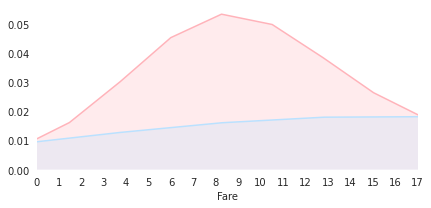

In [41]:
facet = sns.FacetGrid(train_df, hue = 'Survived',aspect=2 )
facet.map(sns.kdeplot, 'Fare', shade= True)
facet.set(xlim=(0 , train_df['Fare'].max()))
sns.despine(left = True,bottom = True)
facet.set(xticks=np.arange(0,21,1))
plt.xlim(0,17)

(17.0, 30.0)

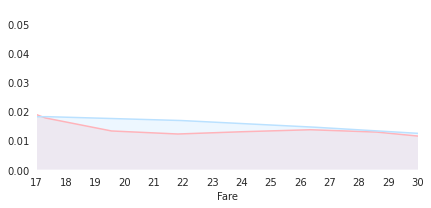

In [42]:
facet = sns.FacetGrid(train_df, hue = 'Survived',aspect=2 )
facet.map(sns.kdeplot, 'Fare', shade= True)
facet.set(xlim=(0 , train_df['Fare'].max()))
sns.despine(left = True,bottom = True)
facet.set(xticks=np.arange(17,31,1))
plt.xlim(17,30)

In [43]:
train_test_df = [train_df, test_df]

for df in train_test_df:
    df.loc[df['Fare'] <= 17, 'Fare'] = 0
    df.loc[(df['Fare'] > 17) & (df['Fare'] <= 30), 'Fare'] = 1
    df.loc[(df['Fare'] > 30) & (df['Age'] <= 100), 'Fare'] = 2
    df.loc[df['Fare'] > 100, 'Fare'] = 3

In [44]:
train_df.head()

,PassengerId,Survived,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,FamilySize,Title
0,1,0,3,0,1.0,A/5 21171,0.0,NaN,0,2,2
1,2,1,1,1,2.0,PC 17599,2.0,C85,1,2,3
2,3,1,3,1,1.0,STON/O2. 3101282,0.0,NaN,0,1,1
3,4,1,1,1,2.0,113803,2.0,C123,0,2,3
4,5,0,3,0,2.0,373450,0.0,NaN,0,1,2


In [45]:
train_df.drop(['PassengerId','Ticket','Cabin'], axis = 1, inplace = True)
test_df.drop(['Ticket','Cabin'], axis = 1, inplace = True)

## Modelling

In [46]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier

In [47]:
X_train = train_df.drop("Survived", axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.drop("PassengerId", axis=1).copy()
X_train.shape, Y_train.shape, X_test.shape

((891, 7), (891,), (418, 7))

In [48]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Pclass      418 non-null    int64  
 1   Sex         418 non-null    int64  
 2   Age         418 non-null    float64
 3   Fare        418 non-null    float64
 4   Embarked    418 non-null    int64  
 5   FamilySize  418 non-null    int64  
 6   Title       418 non-null    int64  
dtypes: float64(2), int64(5)
memory usage: 23.0 KB


## Logistic Regression

In [49]:
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

79.8

## SVM

In [50]:
svc = LinearSVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
acc_svc

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


80.02

## KNN

In [51]:
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
acc_knn

85.19

## Naive Bayes

In [52]:
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
acc_gaussian

78.0

# Perceptron

In [53]:
perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
acc_perceptron

72.5

## Linear SVC

In [54]:
linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
acc_linear_svc

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


80.02

## SGD

In [55]:
sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
acc_sgd

80.36

## Decision Tree

In [56]:
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
acc_decision_tree

88.1

## Random Forest

In [57]:
random_forest = RandomForestClassifier(n_estimators=3)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

86.98

In [58]:
submission = pd.DataFrame({
        "PassengerId": test_df["PassengerId"],
        "Survived": Y_pred
    })
submission.to_csv('submissionRF.csv', index=False)

In [59]:
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree]})
models.sort_values(by='Score', ascending=False)

,Model,Score
8,Decision Tree,88.10
3,Random Forest,86.98
1,KNN,85.19
6,Stochastic Gradient Decent,80.36
0,Support Vector Machines,80.02
7,Linear SVC,80.02
2,Logistic Regression,79.80
4,Naive Bayes,78.00
5,Perceptron,72.50


## Cross Validation (K-Fold)

In [60]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

k_fold = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 1)

In [61]:
from sklearn.model_selection import cross_val_score
rf = RandomForestClassifier(n_estimators=3)
scores = cross_val_score(rf, X_train, Y_train, cv=10, scoring = "accuracy")
print("Scores:", scores)
print("Mean:", scores.mean())
print("Standard Deviation:", scores.std())

Scores: [0.74444444 0.80898876 0.69662921 0.85393258 0.85393258 0.82022472
 0.84269663 0.80898876 0.83146067 0.78651685]
Mean: 0.8047815230961298
Standard Deviation: 0.047881064453864634


In [62]:
importances = pd.DataFrame({'feature':X_train.columns,'Importance':np.round(random_forest.feature_importances_,3)})
importances = importances.sort_values('Importance',ascending=False).set_index('feature')
importances.head(7)

,Importance
feature,
Title,0.279
Sex,0.195
FamilySize,0.149
Pclass,0.138
Fare,0.114
Age,0.083
Embarked,0.043


## Grid Search

In [63]:
from sklearn.model_selection import GridSearchCV

In [64]:
parameters = {'n_estimators': (10,30,50,70,90,100),
             'criterion': ('gini', 'entropy'),
             'max_depth': (3,5,7,9,10),
             'max_features': ('auto', 'sqrt'),
             'min_samples_split': (2,4,6)
             }

In [65]:
RF_grid = GridSearchCV(RandomForestClassifier(n_jobs = -1, oob_score = False), param_grid = parameters, cv = 3, verbose = True)

In [66]:
RF_grid_model = RF_grid.fit(X_train, Y_train)

Fitting 3 folds for each of 360 candidates, totalling 1080 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1080 out of 1080 | elapsed:  3.9min finished


In [67]:
RF_grid_model.best_estimator_

RandomForestClassifier(criterion='entropy', max_depth=5, n_estimators=30,
                       n_jobs=-1)

In [68]:
RF_grid_model.best_score_

0.8327721661054994

## Model Evaluation

## Confusion Matrix

In [69]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
predictions = cross_val_predict(random_forest, X_train, Y_train, cv=3)
confusion_matrix(Y_train, predictions)

array([[479,  70],
       [ 97, 245]])

## Precision and Recall

In [70]:
from sklearn.metrics import precision_score, recall_score

print("Precision:", precision_score(Y_train, predictions))
print("Recall:",recall_score(Y_train, predictions))

Precision: 0.7777777777777778
Recall: 0.716374269005848


## F-Score

In [71]:
from sklearn.metrics import f1_score
f1_score(Y_train, predictions)

0.745814307458143

## Precision Recall Curve

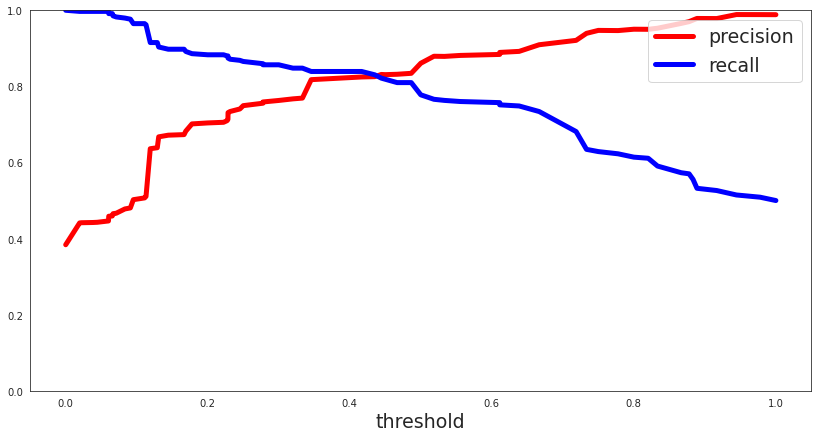

In [72]:
from sklearn.metrics import precision_recall_curve

# getting the probabilities of our predictions
y_scores = random_forest.predict_proba(X_train)
y_scores = y_scores[:,1]

precision, recall, threshold = precision_recall_curve(Y_train, y_scores)
def plot_precision_and_recall(precision, recall, threshold):
    plt.plot(threshold, precision[:-1], "r-", label="precision", linewidth=5)
    plt.plot(threshold, recall[:-1], "b", label="recall", linewidth=5)
    plt.xlabel("threshold", fontsize=19)
    plt.legend(loc="upper right", fontsize=19)
    plt.ylim([0, 1])

plt.figure(figsize=(14, 7))
plot_precision_and_recall(precision, recall, threshold)
plt.show()

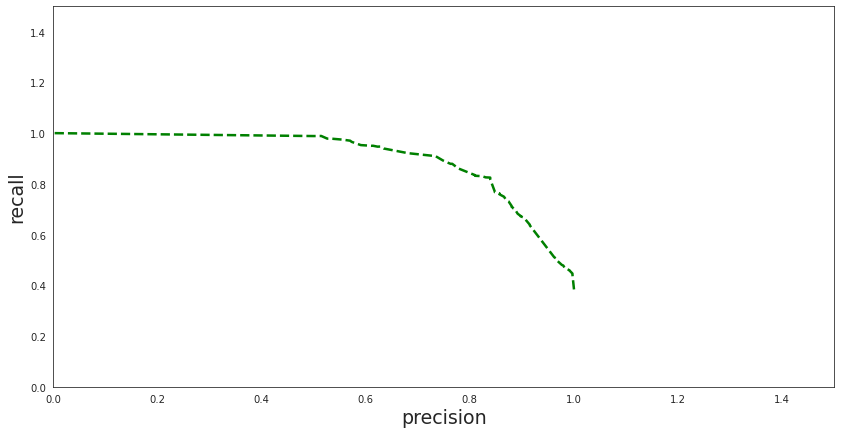

In [73]:
def plot_precision_vs_recall(precision, recall):
    plt.plot(recall, precision, "g--", linewidth=2.5)
    plt.ylabel("recall", fontsize=19)
    plt.xlabel("precision", fontsize=19)
    plt.axis([0, 1.5, 0, 1.5])

plt.figure(figsize=(14, 7))
plot_precision_vs_recall(precision, recall)
plt.show()

## ROC AUC Curve

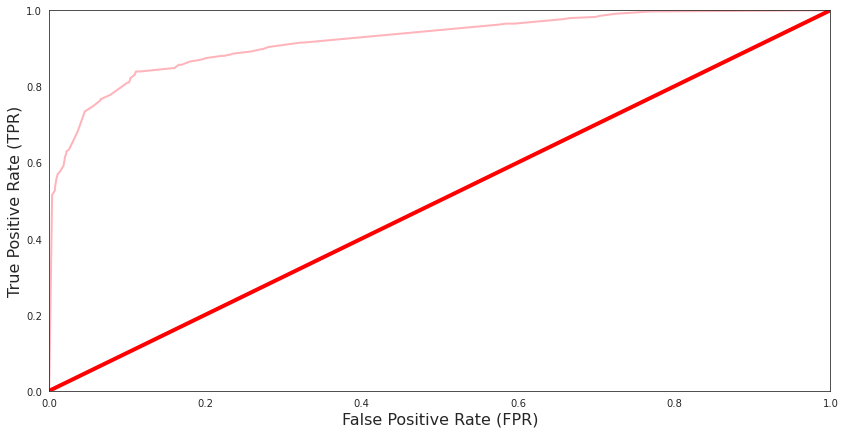

In [74]:
from sklearn.metrics import roc_curve
# compute true positive rate and false positive rate
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_train, y_scores)
# plotting them against each other
def plot_roc_curve(false_positive_rate, true_positive_rate, label=None):
    plt.plot(false_positive_rate, true_positive_rate, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'r', linewidth=4)
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate (FPR)', fontsize=16)
    plt.ylabel('True Positive Rate (TPR)', fontsize=16)

plt.figure(figsize=(14, 7))
plot_roc_curve(false_positive_rate, true_positive_rate)
plt.show()

In [75]:
from sklearn.metrics import roc_auc_score
r_a_score = roc_auc_score(Y_train, y_scores)
print("ROC-AUC-Score:", r_a_score)

ROC-AUC-Score: 0.9213215948188627
